<table><tr>
<td> <img src="../../images/URV.png" style="width: 250px;"/> </td>
<td> <img src="../../images/UOC.jpg" style="width: 250px;"/> </td>
</tr></table>

# Creating models for predicting crypto returns

The objective of this notebook is to establish a model capable of predicting crypto price movements. For that, we will apply all the data seen up until now and use machine learning models for the forcasting. Those models will be:

* Logistic regression
* Naive Bayes
* Support vector classification
* K-Nearest Neighbor
* Decision Tree Classifier
* Random Forest Classifier

At first, we will use a 0 minutes delay, i.e., we will assume when a tweet is published, it has an immediate effect on the price movement. However, it is possible that from the time a tweet is issued until the market corrects may take some time, so we will include a delay variable for subsequent studies.

### Import libraries

In [1]:
import psycopg2
import datetime as dt
import time

from login_access import host, port, user, password

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

from models_module import cont_train_test_X_y_split, min_max_scaler, discr_train_test_X_y_split, LogisticReg, RandomForestClas, DecisionTreeClas, SVC, KNN, NaiveBayes

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn.model_selection
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.svm
import sklearn.neighbors
import sklearn.tree
import sklearn.ensemble
from sklearn.metrics import classification_report

***

<img src="../../images/AVAX.png" style="width: 200px;"/>

***

## Declare Variables

In [2]:
crypto = 'AVAX' #Crypto symbol
delay = 0 #minutes

***

### Fetch data (part 1)

In [3]:
def round_to_next_minute(date, delay = 0):
    remainder = 60 - int(time.mktime(date.timetuple())) % 60 
    date_rounded = int(time.mktime(date.timetuple())) + remainder - delay*60
    #date_rounded_ = dt.datetime.utcfromtimestamp(date_rounded).strftime('%Y-%m-%d %H:%M:%S')
    return float(date_rounded)


def connect_to_db(symbol = None, delay = 0):
    # Connect to DB with credentials
    conn = psycopg2.connect(host=host, database="TwitterDB", port=port, user=user, password=password)

    # Create the cursor to execute SQL commands
    cur = conn.cursor()
    
    # Declare the SQL sentence
    if not symbol: command = "SELECT * FROM crypto_table;"
    else: command = "SELECT * FROM crypto_table WHERE symbol = '{}';".format(symbol)

    # Execute the SQL command
    cur.execute(command)

    # Save execution into a variable
    df = pd.DataFrame(cur.fetchall())
    df.columns=[ col.name for col in cur.description]
    
    # Let's then convert the datetime 'created_at' variable in a unix time variable 
    df['timestamp2'] = [time.mktime(x.timetuple()) for x in df['created_at']]
    
    # Then we pass the function 'round_to_next_minute' where we round to the next minute with 00 seconds
    ## e.g.: from 6h 43min 34sec to 6h 44mins 00 secs
    df['timestamp'] = [round_to_next_minute(x, delay = delay) for x in df['created_at']]
    
    # In order to have only ONE register per minute, in case of conflict we will choose the one 
    # that has the highest retweets
    unique_tweets = np.array(df.groupby('timestamp').max('retweet_count')['tweet_id'])
    df = df[df.tweet_id.isin(unique_tweets)]
    
    # Set that last variable to index for the joining process
    #df.set_index('timestamp', inplace = True)
    
    return df

### Fetch data (part 2)

In [4]:
def crypto_prices(symbol):
    path = '../../../../Crypto prices/'
    price_time_series = pd.read_csv(path + '{}USDT.csv'.format(symbol),
                                    sep='|',
                                    index_col=False,
                                    names=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                                           'tb_quote_a_v', 'tb_base_a_v','quote_a_v', 'trades']).\
                                    drop(['tb_quote_a_v', 'tb_base_a_v','quote_a_v'], axis = 1)
    
    price_time_series['daydate'] = [dt.datetime.utcfromtimestamp(x) for x in price_time_series['timestamp']]
    #price_time_series['daydate'] = [dt.datetime.fromtimestamp(0, datetime.timezone.utc)]
    
    max_date = '2021-12-31 23:59:59'
    max_date = dt.datetime.strptime(max_date, '%Y-%m-%d %H:%M:%S')
    
    price_time_series = price_time_series[price_time_series['daydate'] <= max_date]

    #price_time_series.set_index('timestamp', inplace = True)
    
    return price_time_series

### Unite data

In [5]:
def unite_tables(prices_table, twitter_table):
    df = pd.merge(prices_table, twitter_table, on='timestamp', how='left')
    df['sentiment_score']=np.float64(df['sentiment_score'])
    df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
    df['bin_ret']= [1 if x > 0 else 0 for x in df.log_ret]
    df['dif_timestamp'] = df.timestamp - df.timestamp.shift(1)
    #df.retweet_count.fillna(0, inplace = True)
    df.sentiment_score.fillna(0, inplace = True)
    df.retweet_count.fillna(0, inplace = True)
    df.outcome.fillna('neutral', inplace = True)
    df = df[~df.log_ret.isna()].reset_index()
    return df

In [6]:
df_model = unite_tables(crypto_prices(symbol = crypto), connect_to_db(symbol = crypto, delay = delay))
df_model.head()

,index,timestamp,open,high,low,close,volume,trades,daydate,tweet_id,...,symbol,tweet,retweet_count,sentiment_score,outcome,created_at,timestamp2,log_ret,bin_ret,dif_timestamp
0,1,1600756260,3.6018,4.4804,3.5897,4.2775,295523.2700,1767,2020-09-22 06:31:00,NaN,...,NaN,NaN,0.0000,0.0000,neutral,NaN,NaN,0.0924,1,60.0000
1,2,1600756320,4.2500,4.4351,4.0611,4.1021,137106.9700,1035,2020-09-22 06:32:00,NaN,...,NaN,NaN,0.0000,0.0000,neutral,NaN,NaN,-0.0419,0,60.0000
2,3,1600756380,4.1027,4.2000,4.0061,4.1699,117775.1400,570,2020-09-22 06:33:00,NaN,...,NaN,NaN,0.0000,0.0000,neutral,NaN,NaN,0.0164,1,60.0000
3,4,1600756440,4.1699,4.1990,4.1076,4.1800,72788.2500,475,2020-09-22 06:34:00,NaN,...,NaN,NaN,0.0000,0.0000,neutral,NaN,NaN,0.0024,1,60.0000
4,5,1600756500,4.1704,4.3879,4.0487,4.3350,115621.1200,952,2020-09-22 06:35:00,NaN,...,NaN,NaN,0.0000,0.0000,neutral,NaN,NaN,0.0364,1,60.0000


### Plot correlation between sentiment score and log returns

Pearson correlation: -0.05


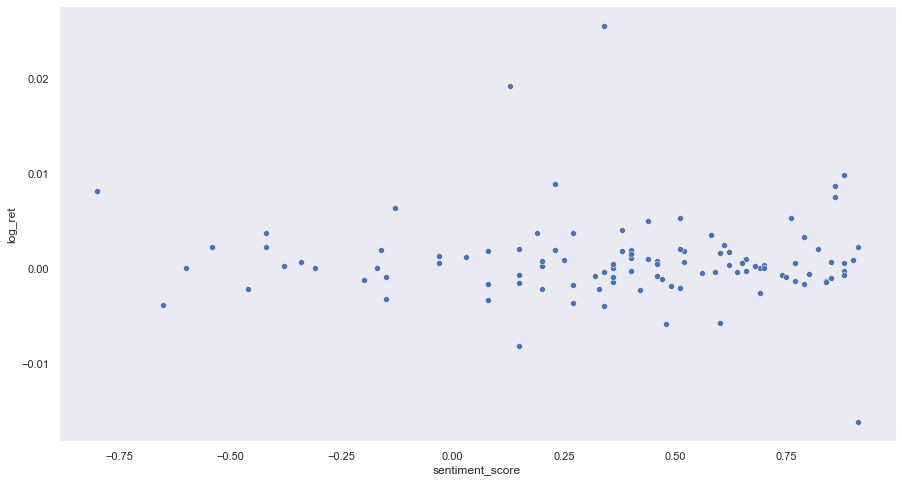

In [7]:
sns.set(rc={'figure.figsize':(15,8)})

sns.set_style("dark")
sns.scatterplot(data=df_model[df_model['sentiment_score'] != 0], x="sentiment_score", y="log_ret")
x = df_model[df_model['sentiment_score'] != 0][['sentiment_score', 'log_ret']]
print('Pearson correlation: {:.2f}'.format(x.corr()['sentiment_score'][1]))

#### Making sure that 99.9% of the data has a step of 60 seconds (or 1 minute) between rows

In [8]:
df_model.dif_timestamp.quantile(0.999) == 60

True

### Extreme returns with and without twitter sentimet

In [9]:
print('Max. log return when no one tweets: {:.2f}%'.format(df_model[df_model['tweet_id'].isna()].log_ret.max()*100))
print('Min. log return when no one tweets: {:.2f}%'.format(df_model[df_model['tweet_id'].isna()].log_ret.min()*100))
print('\n')
print('Max. log return when someone tweets: {:.2f}%'.format(df_model[~df_model['tweet_id'].isna()].log_ret.max()*100))
print('Min. log return when someone tweets: {:.2f}%'.format(df_model[~df_model['tweet_id'].isna()].log_ret.min()*100))

Max. log return when no one tweets: 9.24%
Min. log return when no one tweets: -11.39%


Max. log return when someone tweets: 2.55%
Min. log return when someone tweets: -1.61%


# Models

### Preparing the data

Before feeding the data into the models we first need to split the data into train and test and then scale the X variables using a min max scaler.

In [10]:
# Train test split
X_train, X_test, y_train, y_test = discr_train_test_X_y_split(df_model, features = ['sentiment_score', 'retweet_count'])

In [11]:
# Scaling variables
X_train, X_test = min_max_scaler(X_train, X_test)

In [12]:
print('Shape of the X_train: {}'.format(X_train.shape))
print('Shape of the X_test: {}'.format(X_test.shape))
print('Shape of the y_train: {}'.format(y_train.shape))
print('Shape of the y_test: {}'.format(y_test.shape))

Shape of the X_train: (85, 2)
Shape of the X_test: (22, 2)
Shape of the y_train: (85,)
Shape of the y_test: (22,)


## Model 1: Logistic regression

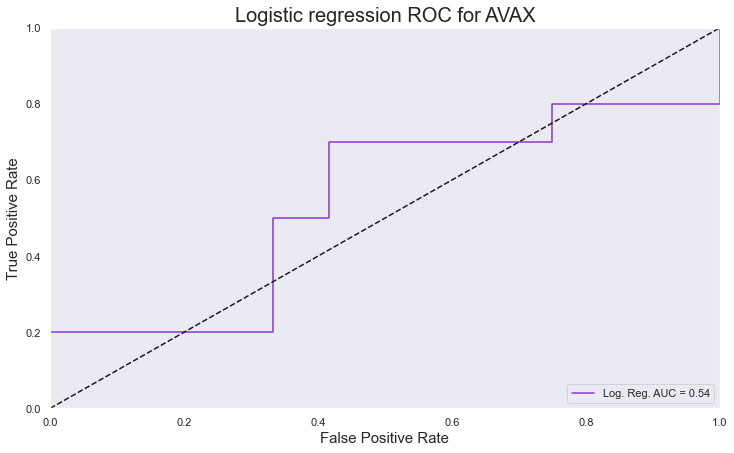

In [13]:
LogisticReg(X_train, y_train, X_test, y_test, random_state=123)
plt.title('Logistic regression ROC for {}'.format(crypto), fontsize=20)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15);

## Model 2: Naive Bayes

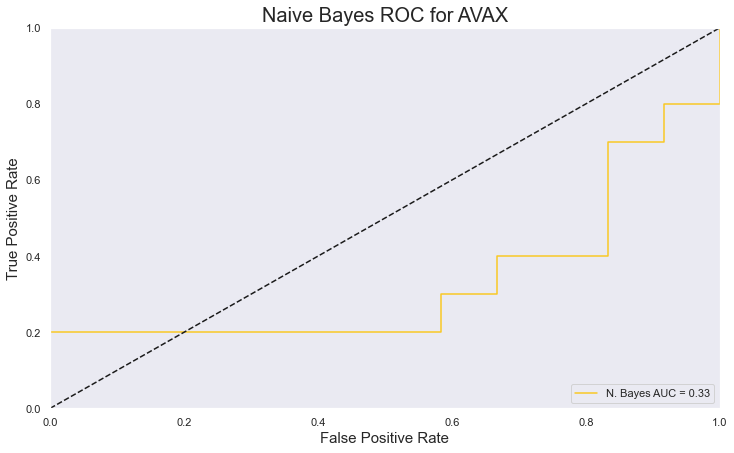

In [14]:
NaiveBayes(X_train, y_train, X_test, y_test)
plt.title('Naive Bayes ROC for {}'.format(crypto), fontsize=20)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15);

## Model 3: Support Vector Classification

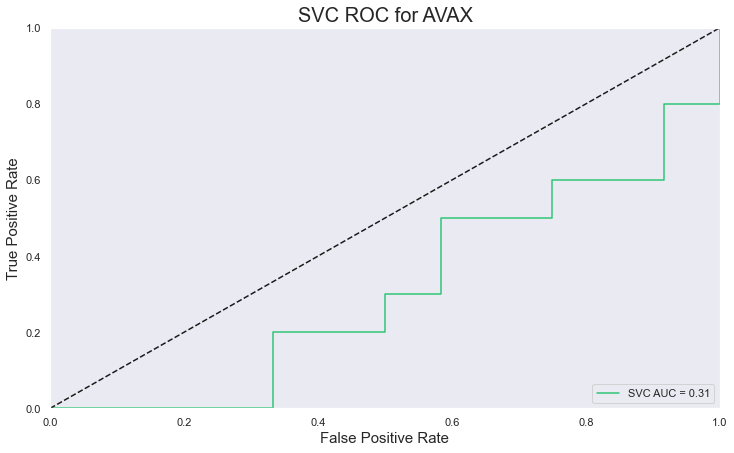

In [15]:
SVC(X_train, y_train, X_test, y_test)
plt.title('SVC ROC for {}'.format(crypto), fontsize=20)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15);

***

## Model 4: K-Nearest Neighbor

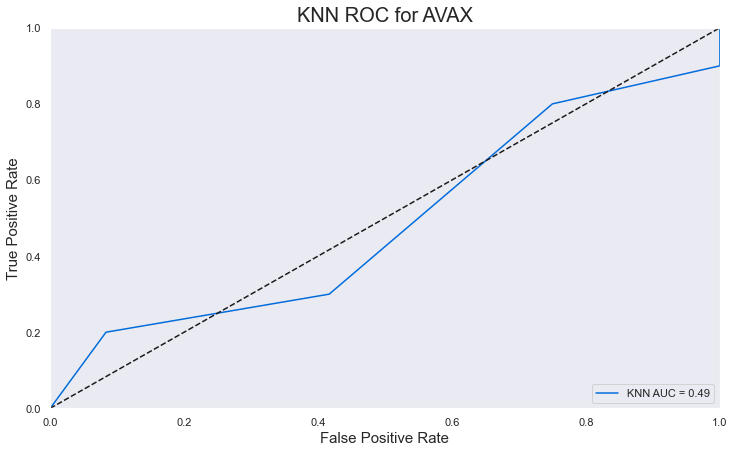

In [16]:
KNN(X_train, y_train, X_test, y_test)
plt.title('KNN ROC for {}'.format(crypto), fontsize=20)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15);

***

## Model 5: Decision Tree Classifier

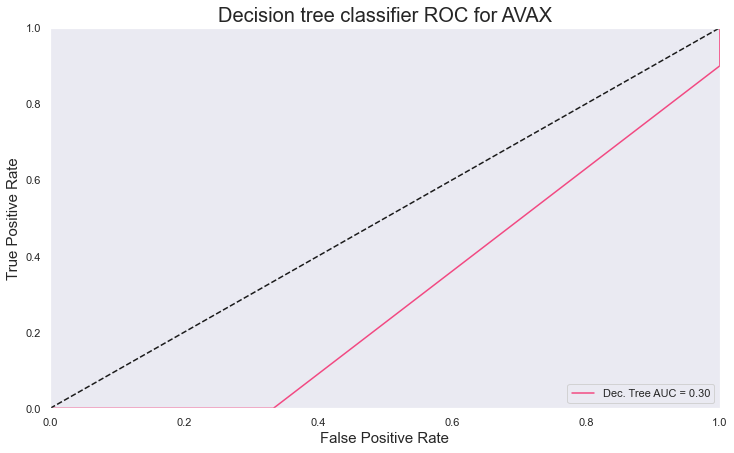

In [17]:
DecisionTreeClas(X_train, y_train, X_test, y_test, random_state=123)
plt.title('Decision tree classifier ROC for {}'.format(crypto), fontsize=20)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15);

***

## Model 6: Random Forest Classifier

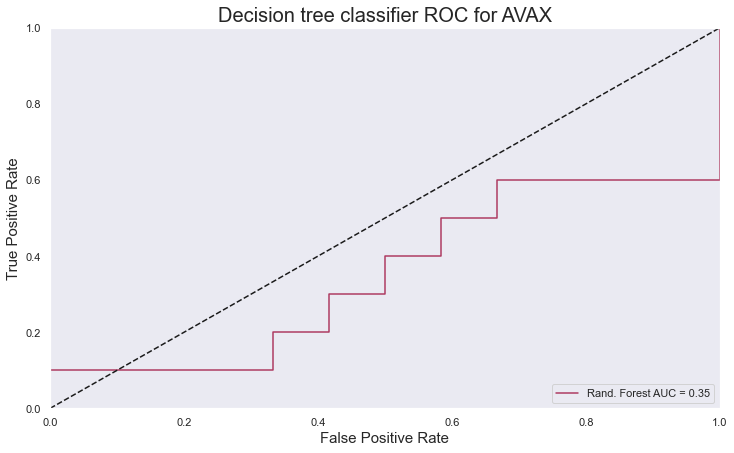

In [18]:
RandomForestClas(X_train, y_train, X_test, y_test, random_state=123)
plt.title('Decision tree classifier ROC for {}'.format(crypto), fontsize=20)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15);

***

# What if we delayed the the returns?

In this scenario we will assume that the impact of tweets on prices have some sort of delay. We will assume 3 scenarios where 1, 2 and 5 minutes delays will be studied.

In [19]:
def scenario_creator(list_of_delays = []):
    
    LRauc, NBauc, SVCauc, KNNauc, DTCauc, RFCauc, time = [], [], [], [], [], [], []
    
    for minute in list_of_delays:
        
        df_model = unite_tables(crypto_prices(symbol = crypto), connect_to_db(symbol = crypto, delay = minute))
        
        X_train, X_test, y_train, y_test = discr_train_test_X_y_split(df_model, features = ['sentiment_score'])
        
        X_train, X_test = min_max_scaler(X_train, X_test)
        
        time.append(minute)
        
        LRauc.append(LogisticReg(X_train, y_train, X_test, y_test, random_state=123))
        
        NBauc.append(NaiveBayes(X_train, y_train, X_test, y_test))
        
        SVCauc.append(SVC(X_train, y_train, X_test, y_test))
        
        KNNauc.append(KNN(X_train, y_train, X_test, y_test))
        
        DTCauc.append(DecisionTreeClas(X_train, y_train, X_test, y_test, random_state=123))
        
        RFCauc.append(RandomForestClas(X_train, y_train, X_test, y_test, random_state=123))
        

    results = {'Delayed mins':time,
               'Log. Reg.': LRauc,
               'Naive Bayes': NBauc,
               'SVC': SVCauc,
               'KNN':KNNauc,
               'Decision tree': DTCauc,
               'Random Forest': RFCauc}
        
        
    return pd.DataFrame(results).set_index('Delayed mins')

In [20]:
results = scenario_creator(list_of_delays = [0, 1, 2, 5])
plt.close()

In [21]:
results

,Log. Reg.,Naive Bayes,SVC,KNN,Decision tree,Random Forest
Delayed mins,,,,,,
0,0.3350,0.6650,0.3350,0.3440,0.1290,0.2100
1,0.5000,0.4580,0.5830,0.3080,0.3710,0.4370
2,0.4000,0.3330,0.2830,0.3750,0.4210,0.3420
5,0.5990,0.5990,0.5990,0.4920,0.4170,0.4260
